# Deepwalk performance debugging: absolute minimal hetionet

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

from itertools import chain

from glob import glob
import os
import seaborn as sns

In [2]:
%matplotlib inline

---

if no embedding for training data


In [3]:
def add_features(df, features, mergetype):
    return (df
        .merge(
            features, how=mergetype, left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how=mergetype, left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize, mergetype):
    reg = add_features(df, features, mergetype)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

there are nodes in the holdout dataset that did not have any embeddings generated for it. check to see if they had proper adjlists made

In [4]:
def eval_performance(fbase, K, vecsize):
    for idx in range(K):
        train = pd.read_csv(
            "tmp/data/train/{}_train_{}.tsv".format(fbase, idx),
            sep='\t'
        )
        
        holdout = pd.read_csv(
            "tmp/data/holdout/{}_holdout_{}.tsv".format(fbase, idx),
            sep='\t'
        )

        features = pd.read_csv(
            "tmp/data/embeddings/{}_embedding_{}.txt".format(fbase, idx),
            sep=" ", skiprows=1,
            names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
        )
        

        tmp = convolv_features(train, features, vecsize, "inner")
        
        print(tmp.shape)
#         print(tmp["etype"].value_counts())

        feat_cols = ["conv{}".format(j) for j in range(vecsize)]
        regmodel = LogisticRegression(C=1e9).fit(tmp[feat_cols], tmp["etype"])

        # test on holdout
        test = convolv_features(
            holdout.drop("etype", axis=1),
            features, vecsize, "left"
        )
        
        assert len(test) == len(holdout)
        
        # if there are empty ones in the features column,
        # then we didn't generate any embeddings, and therefore
        # need to split those up and treat as zeroes
        # for the others we can predict normally, then join together
        
        regular = test[test["conv0"].notnull()].assign(missed = False)
        
        missed = (test[test["conv0"].isnull()]
            .assign(
                predval = 0
            )
            .assign(missed = True)
        )
  
        print(regular.shape)
        print(missed.shape)
                
        # add in predictions
        ans = regular.assign(
            predval = lambda df: regmodel.predict_proba(df[feat_cols])[:, 1]
        )
        
        ans = ans.append(missed)
        
        assert len(ans) == len(holdout)
        
        yield (ans
            [["chemical_uid", "disease_uid", "predval", "missed"]]
            .merge(
                holdout[["chemical_uid", "disease_uid", "etype"]],
                how="inner", on=["chemical_uid", "disease_uid"]
            )
            .sort_values("predval", ascending=False)
            .reset_index(drop=True)
        )

In [5]:
def finished(fbase, K):
    for i in range(K):
        ename = "tmp/data/embeddings/{}_embedding_{}.txt".format(fbase, i)
        
        if not os.path.isfile(ename):
            return False

    return True

need to check that we have the expected embeddings for the concepts

In [34]:
vecsize = 128

stuff = []

missed = []
# for edge_fname in tqdm(chain(
    
for edge_fname in tqdm(glob("tmp/edges/*.tsv")):
    
#     glob("tmp/edges/empty*.tsv"), glob("tmp/edges/drug*.tsv"))):
    fbase = edge_fname.split("/")[2][:-4]
    
    vecsize = 128
    if fbase == "empty_small":
        vecsize = 16
    
    K = 1
    
    # check if all K embeddings are done
    if finished(fbase, K):
        
        print("working on {}".format(fbase))

        aucs = []
        for res in eval_performance(fbase, K, vecsize):
            
            stuff.append(res)
            
            precision, recall, thresh = precision_recall_curve(res["etype"], res["predval"])
            
#             fpr, tpr, thresh = roc_curve(res["etype"], res["predval"])

            auc_val = auc(recall, precision)
            
#             auc_val = auc(fpr, tpr)
            aucs.append(auc_val)
            
            missed.append((res["missed"].sum(), len(res), len(res.query("missed and etype == 1"))))

        temp = (pd
            .Series(aucs)
            .to_frame("auc_roc")
            .assign(edge_val = fbase)
        )
        
        temp.to_csv(
            "tmp/results/{}.tsv".format(fbase), sep='\t', index=False
        )
        
        print("finished working on {}".format(fbase))

  0%|          | 0/5 [00:00<?, ?it/s]

working on no_drug_gene_or_drug_disease2
(11695, 133)
(80902, 133)
(13112, 134)


 20%|██        | 1/5 [00:03<00:12,  3.10s/it]

finished working on no_drug_gene_or_drug_disease2
working on empty
(11695, 133)
(62944, 133)
(31070, 134)


 40%|████      | 2/5 [00:04<00:07,  2.48s/it]

finished working on empty
working on drug_drug_anat_gene_only
(11695, 133)
(63278, 133)
(29350, 134)


 60%|██████    | 3/5 [00:07<00:05,  2.57s/it]

finished working on drug_drug_anat_gene_only
working on no_drug_gene_or_drug_disease
(11695, 133)
(80902, 133)
(13112, 134)


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]

finished working on no_drug_gene_or_drug_disease
working on empty_small
(11695, 21)
(859, 21)
(311, 22)
finished working on empty_small


---

In [27]:
mdata = pd.DataFrame(missed, columns=["num_missed", "total", "missed_and_true"])

In [28]:
mdata.shape

(3, 3)

In [29]:
mdata

,num_missed,total,missed_and_true
0,31070,94014,119
1,311,1170,119
2,29350,92628,110


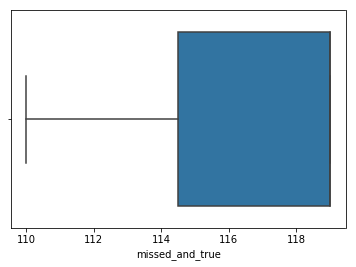

In [30]:
sns.boxplot(mdata["missed_and_true"])

seems to have been no difference in performance between the version where some of the gold standard is in the network vs gold standard relations are removed from the network

---

In [35]:
res = [
    pd.read_csv(fname, sep='\t')
    for fname in glob("tmp/results/*.tsv")
]

res = pd.concat(res)

In [36]:
res.shape

(5, 2)

In [37]:
res

,auc_roc,edge_val
0,0.176056,no_drug_gene_or_drug_disease2
0,0.122008,empty
0,0.147716,drug_drug_anat_gene_only
0,0.133609,no_drug_gene_or_drug_disease
0,0.850847,empty_small


In [23]:
res

,auc_roc,edge_val
0,0.853603,no_drug_gene_or_drug_disease2
0,0.782379,empty
0,0.791529,drug_drug_anat_gene_only
0,0.861440,no_drug_gene_or_drug_disease
1,0.872229,no_drug_gene_or_drug_disease
2,0.839946,no_drug_gene_or_drug_disease
3,0.882665,no_drug_gene_or_drug_disease
4,0.864650,no_drug_gene_or_drug_disease
0,0.789577,empty_small


In [38]:
res.groupby("edge_val").mean()

,auc_roc
edge_val,
drug_drug_anat_gene_only,0.147716
empty,0.122008
empty_small,0.850847
no_drug_gene_or_drug_disease,0.133609
no_drug_gene_or_drug_disease2,0.176056


at this point it's clear that the way we construct the network itself with true training examples as edges in the network is influencing how the algorithm determines which things to predict

as long as we include the 

even on a network containing only the gold standard edges which are known to be true, we are getting 0.78 ROC values.

---

In [15]:
# original deepwalk performance on unmodified hetionet
orig = [0.83794169828897624,
 0.83592900230751011,
 0.82794024342944517,
 0.83258454954099403,
 0.84911988472878375,
 0.82679078477519785,
 0.86955409367485537,
 0.81721305005383327,
 0.82568604664477641,
 0.85703519382275861]

In [16]:
hetio_perf = (pd
    .Series(orig)
    .to_frame("auc_roc")
    .assign(pct_kept = 100)
)

In [17]:
hetio_perf.head()

,auc_roc,pct_kept
0,0.837942,100
1,0.835929,100
2,0.827940,100
3,0.832585,100
4,0.849120,100


In [18]:
hetio_perf["auc_roc"].mean()

0.8379794547267132